# Clustering with PyTorch

"PyTorch is a python package that provides [...]
Tensor computation (like numpy) with strong GPU acceleration [...]"

So, let's use it for some Mean-shift clustering.

In [1]:
import math
import operator

import numpy as np
import matplotlib.pyplot as plt

import torch

%matplotlib inline

# Mean shitft clustering with numpy

## Create data

In [2]:
n_clusters = 6
n_samples = 1000

To generate our data, we're going to pick `n_clusters` random points, which we'll call centroids, and for each point we're going to generate `n_samples` random points about it.

In [3]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
          for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

Plot the data and the centroids:

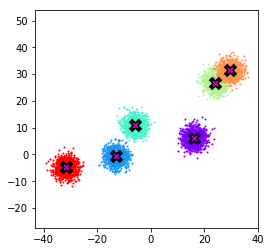

In [4]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))

    fig, ax = plt.subplots(figsize=(4, 4))
    for i, centroid in enumerate(centroids):
        samples = data[i * n_samples : (i + 1) * n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], c=colour[i], s=1)
        ax.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        ax.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)
    plt.axis('equal')
    
plot_data(centroids, data, n_samples)

## The mean shift algorithm

"Mean shift is a **non-parametric** feature-space analysis technique for locating the maxima of a density function, a so-called **mode-seeking algorithm**. Application domains include cluster analysis in computer vision and image processing." -- https://en.wikipedia.org/wiki/Mean_shift

Think of mean-shift clustering as k-means but you don't have to specify the number of clusters.
(You have to specify the **bandwidth** but that can be automated.)

Algo:
```python
# PSEUDO CODE
while not_converged():
    for i, point in enumerate(points):
        # distance for the given point to all other points
        distances = calc_distances(point, points)
        
        # turn distance into weights using a gaussian
        weights = gaussian(dist, bandwidth=2.5)
        
        # update the weights by using the weights
        points[i] = (weights * points).sum(0) / weights.sum()

return points
```

## The implementation

Let's implement this with numpy:

In [5]:
from numpy import exp, sqrt, array

In [6]:
def distance(x, X):
    # return np.linalg.norm(x - X, axis=1)
    return sqrt(((x - X)**2).sum(1))

Let's try it out. (More on how this function works shortly)

In [7]:
a = array([1, 2])
b = array([[1, 2],
           [2, 3],
           [-1, -3]])

dist = distance(a, b)
dist

array([0.        , 1.41421356, 5.38516481])

In [8]:
def gaussian(dist, bandwidth):
    return exp(-0.5 * ((dist / bandwidth))**2) / (bandwidth * math.sqrt(2 * math.pi))

In [9]:
gaussian(dist, 2.5)

array([0.15957691, 0.13598247, 0.0156822 ])

Now we can do a single mean shift step:

In [10]:
def meanshift_step(X, bandwidth=2.5):
    for i, x in enumerate(X):
        dist = distance(x, X)
        weight = gaussian(dist, bandwidth)
        X[i] = (weight[:, None] * X).sum(0) / weight.sum()
    return X

Data before:

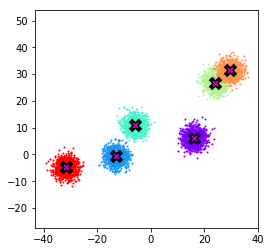

In [11]:
plot_data(centroids, data, n_samples)

Data after:

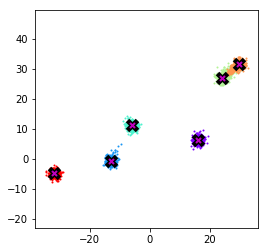

In [12]:
_X = meanshift_step(np.copy(data))
plot_data(centroids, _X, n_samples)

Just repeath this/iterate a few times and we have the complete mean shift algorithm:

In [13]:
def meanshift(X):
    X = np.copy(X)
    for _ in range(5):
        X = meanshift_step(X)
    return X

In [14]:
%%time
X = meanshift(data)

CPU times: user 1min 33s, sys: 3.31 s, total: 1min 36s
Wall time: 12.1 s


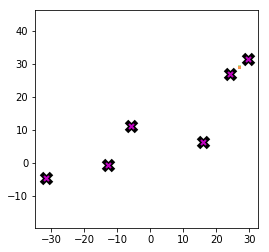

In [15]:
plot_data(centroids, X, n_samples)

# Mean shift in PyTorch (with GPU)

PyTorch is like numpy and the interface is very similar.

We actually don't have to adjust anything really to use torch instead of numpy.

In [16]:
import torch
from torch import exp, sqrt

We oncly have to copy the data into a PyTorch GPU tensor.

In [17]:
def meanshift_torch(X):
    X = torch.from_numpy(np.copy(X)).cuda()
    for it in range(5):
        X = meanshift_step(X)
    return X

CPU times: user 7.3 s, sys: 1.1 s, total: 8.41 s
Wall time: 8.42 s


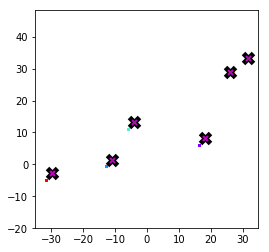

In [18]:
%time X = meanshift_torch(data).cpu().numpy()
plot_data(centroids+2, X, n_samples)

Same results, but the implementation is about the same speed.

CUDA kernels have to be started for each calculation and the kernels don't have enough to do.
Let's not process individual points, but batches of points.

## Batch processing

In [19]:
def distance_batch(a, b):
    return sqrt(((a[None,:] - b[:,None]) ** 2).sum(2))

In [20]:
a = torch.rand(2, 2)
b = torch.rand(3, 2)
distance_batch(b, a)

tensor([[ 0.6670,  0.4303,  0.2015],
        [ 0.7339,  0.4600,  0.1328]])

`distance_batch` contains some broadcast magic that allows us to compute the distance from each point in a batch to all points in the data.

In [21]:
def meanshift_torch2(data, batch_size=500):
    n = len(data)
    X = torch.from_numpy(np.copy(data)).cuda()
    for _ in range(5):
        for i in range(0, n, batch_size):
            s = slice(i, min(n, i + batch_size))
            weight = gaussian(distance_batch(X, X[s]), 2.5)
            num = (weight[:, :, None] * X).sum(dim=1)
            X[s] = num / weight.sum(1)[:, None]
    return X

In [22]:
%time X = meanshift_torch2(data, batch_size=1).cpu().numpy()

CPU times: user 5.01 s, sys: 316 ms, total: 5.33 s
Wall time: 5.33 s


In [23]:
%time X = meanshift_torch2(data, batch_size=10).cpu().numpy()

CPU times: user 541 ms, sys: 32 ms, total: 573 ms
Wall time: 571 ms


In [24]:
%time X = meanshift_torch2(data, batch_size=100).cpu().numpy()

CPU times: user 218 ms, sys: 120 ms, total: 338 ms
Wall time: 336 ms


In [25]:
%time X = meanshift_torch2(data, batch_size=1000).cpu().numpy()

CPU times: user 193 ms, sys: 104 ms, total: 297 ms
Wall time: 297 ms


In [26]:
%time X = meanshift_torch2(data, batch_size=6000).cpu().numpy()

CPU times: user 215 ms, sys: 92 ms, total: 307 ms
Wall time: 306 ms


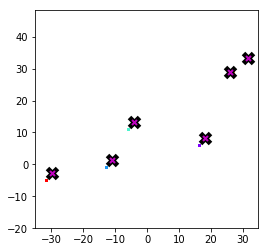

In [27]:
plot_data(centroids+2, X, n_samples)

# Mean shift in scikit-learn

Of course, sklearn also offers `MeanShift`.
Let's see how it performs

In [28]:
from sklearn.cluster import MeanShift

In [29]:
%%time
model = MeanShift()
model.fit(data)

CPU times: user 17.3 s, sys: 416 ms, total: 17.7 s
Wall time: 6.32 s


This is a faster than our naive implementation, but much slower than the GPU version.


# Note
Keep in mind that this demo is not saying that A is faster than B.
It rather shows that you can use PyTorch in fun ways!

Ref:
- https://pytorch.org/docs/stable/notes/broadcasting.html
- https://pytorch.org/docs/stable/notes/cuda.html
- https://github.com/fastai/fastai/blob/master/tutorials/meanshift.ipynb